Importi potrebni za projekat

In [51]:
from tensorflow import keras 
from keras.layers import Dense, Reshape, Flatten, Convolution2D, Conv2DTranspose, ReLU, LeakyReLU, Dropout, Input, BatchNormalization, Conv2D
from tensorflow.keras.utils import plot_model 
from tensorflow.keras.optimizers import Adam 
import tensorflow_datasets as tfds
from keras import layers
import numpy as np
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize
import tensorflow as tf
import sklearn
from scipy.stats import norm
from matplotlib import pyplot as plt
from scipy.stats import wasserstein_distance
from tqdm import tqdm
import cv2 
import matplotlib 
import matplotlib.pyplot as plt

import sys
import os
main_dir=os.path.dirname(sys.path[0])


## Wasserstein GAN 

Wasserstein GAN koristi strukturu modela kao DCGAN, ali postoji jedna bitna razilka, za loss funkciju koristi se wasserstein (Earth Mover) distanca. Da bismo razumeli zasto se koristi, bitno je razumeti nedostatke loss funkcije koja se koristi u DCGAN modelu.

Pre nego što krenemo sa objašnjavanjem DCGAN loss funkcije bitno je razumeti dve metrike koje se koriste za kvantifikovanje sličnosti između dve distribucije
  1. KL (Kullback–Leibler) divergencija
  2. JS (Jensen–Shannon) divergencija

## KL divergencija
Meri koliko ditribucija p divergira od ocekivane distribucije q

\begin{aligned}D_{KL}(p \| q) = \int_x p(x) \log \frac{p(x)}{q(x)} dx\end{aligned}


Dkl je minimalno ukoliko je p(x) = g(x) za svako x

## JS divergencija
Meri isto što i KL divergencija ali je za razliku od nje, simetrična

\begin{aligned}D_{JS}(p \| q) = \frac{1}{2} D_{KL}(p \| \frac{p + q}{2}) + \frac{1}{2} D_{KL}(q \| \frac{p + q}{2})\end{aligned}

Loss funkcija koja se koristi za treniranje GAN modela:
\begin{aligned}L(G, D) = \int_x \bigg( p_{r}(x) \log(D(x)) + p_g (x) \log(1 - D(x)) \bigg) dx\end{aligned}

Intuitivno, ukoliko generator generise podatke koje dikriminator ne moze da raspozna od realnih primeraka, tako da je p_r = p_g, šanse da diskrimator uspešno raspozna su 50%.
Dakle, možemo reći da za optimalni diskrimantor **D***, vazi **D***(x) = 0.5.
Prethodna jednačina se može predstaviti kao:

\begin{aligned}
L(G, D^*) 
&= \int_x \bigg( p_{r}(x) \log(D^*(x)) + p_g (x) \log(1 - D^*(x)) \bigg) dx \\
&= \log \frac{1}{2} \int_x p_{r}(x) dx + \log \frac{1}{2} \int_x p_g(x) dx \\
&= -2\log2
\end{aligned}

Konačno, možemo primetiti da se prethodna loss funkcija može izraziti preko JS divergencije:


\begin{aligned}
D_{JS}(p_{r} \| p_g) 
=& \frac{1}{2} D_{KL}(p_{r} || \frac{p_{r} + p_g}{2}) + \frac{1}{2} D_{KL}(p_{g} || \frac{p_{r} + p_g}{2}) \\
=& \frac{1}{2} \bigg( \log2 + \int_x p_{r}(x) \log \frac{p_{r}(x)}{p_{r} + p_g(x)} dx \bigg) + \\& \frac{1}{2} \bigg( \log2 + \int_x p_g(x) \log \frac{p_g(x)}{p_{r} + p_g(x)} dx \bigg) \\
=& \frac{1}{2} \bigg( \log4 + L(G, D^*) \bigg)
\end{aligned}

Dakle,

\begin{aligned}L(G, D^*) = 2D_{JS}(p_{r} \| p_g) - 2\log2\end{aligned}

## Problemi sa JS i KL divergencijom

In [ ]:
def kld(d1,d2,eps=10^-6):
    return np.sum(d1*np.log((d1)/(d2)))

def jsd(d1,d2):
    return 0.5 * kld(d1,(d1+d2)/2) + 0.5 * kld(d2,(d1+d2)/2)

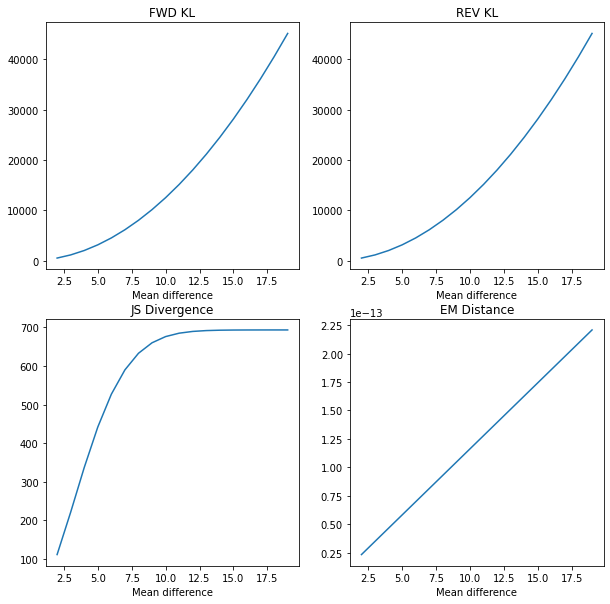

In [ ]:
x = np.arange(-40, 40, 0.001)
q_mean_range = (2,20)
fkl = []
bkl = []
js = []
em = []
p = norm.pdf(x, 0, 2)
for i in range(*q_mean_range):
    q = norm.pdf(x, i, 2)
    fkl.append(kld(p,q))
    bkl.append(kld(q,p))
    js.append(jsd(p,q))
    em.append(wasserstein_distance(p,q))
x = np.arange(*q_mean_range,1)
f,ax = plt.subplots(2,2,figsize=(10,10))
ax = ax.flatten()
for i,(vals,name) in enumerate(zip([fkl,bkl,js,em],['FWD KL','REV KL','JS Divergence','EM Distance'])):
    ax[i].plot(x,vals)
    ax[i].set_xlabel('Mean difference')
    ax[i].set_title(name)
plt.show()

Na primeru iznad, prikazano je kako se razlicite metrike ponašaju kad se očekivana vrednost distribucije q udaljava od očekivane vrednosti distribucije p.
KL divergencija poraste eksponencijalno, JS divergencija se posle nekog vremena stacionira, dok se Earth-Mover(Wasserstein) distanca povećava linearno, što deluje najbolje za treniranje GAN modela.

## Wasserstein distanca

Wasserstein distanca je mera koja nam govori koliko se minimalno "energije" mora utrošiti da bi se oblik jedne distribucije prebacio u oblik željene distribucije. Može se zapisati u sledećem obliku:

\begin{align}W(p_r, p_g) = \inf_{\gamma \sim \Pi(p_r, p_g)} \mathbb{E}_{(x, y) \sim \gamma}[\| x-y \|]\end{align}

Pošto je veoma skupo od svih mogućih planova transportacije jedne distribucije u drugu tražiti optimalnu, na osnovu Kantorovich-Rubinstein dualiteta dobijamo:

\begin{align}W(p_r, p_g) = \frac{1}{K} \sup_{\| f \|_L \leq K} \mathbb{E}_{x \sim p_r}[f(x)] - \mathbb{E}_{x \sim p_g}[f(x)]\end{align}

Da bi ova formulacija bila zadovoljena, funkcija **f** mora da zadovolji \begin{align}| f |_L \leq K\end{align} što znači da mora biti K-Lipschitz kontinualna.

Ovo se može ostvariti na više načina:
  1. Parametre diskriminatora ograničimo da budu u kompaktnom prostoru, na primer između -0.01 i 0.01
  2. Funkcija f je K-Lipschitz kontinualna ukoliko ima gradiente sa normom ne većim od 1

Prvi način je u naučnom radu opisan kao nedovoljan, i u ovom radu nije dao rezultate vredne pokazivanja

Drugi način je implementiran pomoću gradient penalty metode


In [ ]:
def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

Prema propoziciji iz naučnog rada, parametri optimalnog diskriminatora sadrže prave sa normom gradienta ne većom od 1 koje povezuju primerke iz p_g i p_r distribucije (slika ispod). Za sve prave koje to ne zadovoljavaju dodaje se kazneni parametar na loss diskriminatora

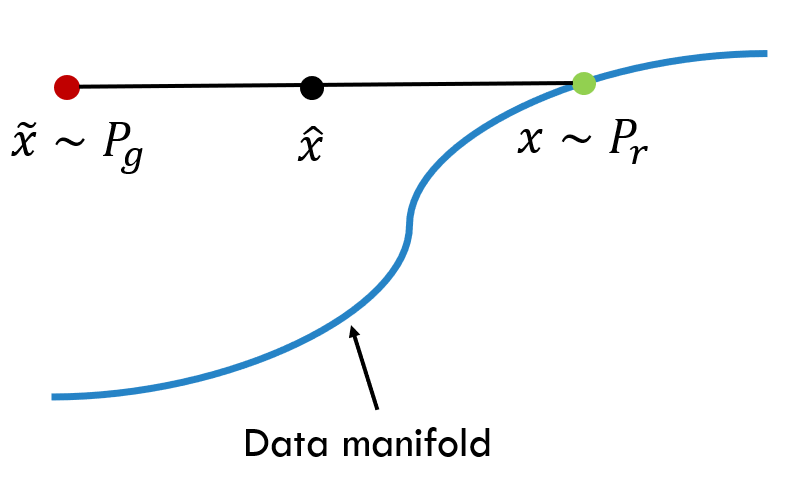

## Pseudo Algoritam

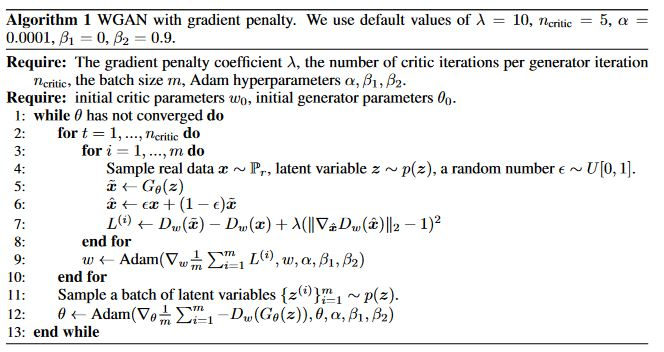

## Generator
Za generator koristi se DCGAN generator

In [55]:
class Generator(tf.keras.Model):
    def __init__(self, latent_dim):
        super().__init__()
        self.n_nodes = 4 * 4 * 1024
        self.latent_dim = latent_dim
        self.fc1_layer = Dense(self.n_nodes, input_dim=(latent_dim, ), activation='relu')
        self.reshape_layer = Reshape((4, 4, 1024))
        self.batch_norm1 = BatchNormalization()
        self.batch_norm2 = BatchNormalization()
        self.batch_norm3 = BatchNormalization()
        self.batch_norm4 = BatchNormalization()
        self.cnv1_layer = Conv2DTranspose(filters=128, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='relu')
        self.cnv2_layer = Conv2DTranspose(filters=256, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='relu')
        self.cnv3_layer = Conv2DTranspose(filters=512, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='relu')
        self.cnv4_layer = Conv2DTranspose(filters=3, kernel_size=(5, 5), strides=(2, 2), activation='sigmoid', padding='same')

    def call(self, input_tensor, training=False):
        x = self.fc1_layer(input_tensor, training=training)
        x = self.batch_norm1(x)
        x = self.reshape_layer(x)
        x = self.cnv1_layer(x, training=training)
        x = self.batch_norm2(x)
        x = self.cnv2_layer(x, training=training)
        x = self.batch_norm3(x)
        x = self.cnv3_layer(x, training=training)
        x = self.batch_norm4(x)
        x = self.cnv4_layer(x, training=training)
        return x

    @staticmethod
    def loss(fake_img):
        return -tf.reduce_mean(fake_img)

    def summary(self):
        x = tf.keras.Input(shape=(self.latent_dim, ))
        model = tf.keras.Model(inputs=[x], outputs=self.call(x))
        return model.summary()



## Diskriminator
Za diskriminator se koristi struktura identicna DCGAN diskriminatoru, jedina razlika jesto to što se za poslednji dense sloj ne koristi aktivaciona funkcija. U slučaju WGAN-a, diskriminator ne govori da li je slika realna ili nije, vec ukazuje na to koliko je slika realna. Ovakvom implementacijom omogucujemo diskriminatoru da maksimizuje udaljenost između distribucija. Iz navedenih razloga, umesto diskriminator, često se koristi naziv *Critic*

In [56]:
class Critic(tf.keras.Model):
    def __init__(self, in_shape, n_critic):
        super().__init__()
        self.n_critic = n_critic
        self.in_shape = in_shape
        self.leaky_relu1 = LeakyReLU(alpha=0.2)
        self.leaky_relu2 = LeakyReLU(alpha=0.2)
        self.leaky_relu3 = LeakyReLU(alpha=0.2)
        self.leaky_relu4 = LeakyReLU(alpha=0.2)
        self.drop_out_layer1 = Dropout(0.3)
        self.drop_out_layer2 = Dropout(0.3)
        self.batch_norm1 = BatchNormalization()
        self.batch_norm2 = BatchNormalization()
        self.batch_norm3 = BatchNormalization()
        self.cnv1_layer = Conv2D(filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=in_shape)
        self.cnv2_layer = Conv2D(filters=128, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=in_shape)
        self.cnv3_layer = Conv2D(filters=256, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=in_shape)
        self.cnv4_layer = Conv2D(filters=512, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=in_shape)
        self.output_layer = Dense(1)

    def call(self, input_tensor, training=False):
        x = self.cnv1_layer(input_tensor, training=training)
        x = self.leaky_relu1(x)
        x = self.cnv2_layer(x, training=training)
        x = self.batch_norm1(x)
        x = self.leaky_relu2(x)
        x = self.drop_out_layer1(x)
        x = self.cnv3_layer(x, training=training)
        x = self.batch_norm2(x)
        x = self.leaky_relu3(x)
        x = self.drop_out_layer2(x)
        x = self.cnv4_layer(x, training=training)
        x = self.batch_norm3(x)
        x = self.leaky_relu4(x)
        x = Flatten()(x)
        x = Dropout(0.3)(x)
        return self.output_layer(x)

    @staticmethod
    def loss(real_img, fake_img):
        real_loss = tf.reduce_mean(real_img)
        fake_loss = tf.reduce_mean(fake_img)
        return fake_loss - real_loss

    def summary(self):
        x = tf.keras.Input(shape=self.in_shape)
        model = tf.keras.Model(inputs=[x], outputs=self.call(x))
        return model.summary()



#### Trening modela
Treniramo WGAN iterativno optimizujući diskriminator i generator koristeci *Adam* algoritam.

In [57]:
import numpy as np

import tensorflow as tf

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.0, beta_2=0.9)
critic_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.0, beta_2=0.9)

class WGANModel:
    def __init__(self, generator, critic, gp_weight=10):
        self.generator = generator
        self.critic = critic
        self.gp_weight = gp_weight

    def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp


    @tf.function
    def train_step(self, images, latent_dim, batch_size):

        
        for i in range(self.critic.n_critic):
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, latent_dim)
            )
            with tf.GradientTape() as disc_tape:
                generated_images = self.generator(random_latent_vectors, training=True)
                fake_logits = self.critic(generated_images, training=True)
                real_logits = self.critic(images, training=True)
                d_cost = self.critic.loss(real_img=real_logits, fake_img=fake_logits)
                gp = self.gradient_penalty(batch_size, images, generated_images)
                critic_loss = d_cost + gp * self.gp_weight

            gradients_of_critic = disc_tape.gradient(critic_loss, self.critic.trainable_variables)
            critic_optimizer.apply_gradients(zip(gradients_of_critic, self.critic.trainable_variables))

        random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors, training=True)
            gen_img_logits = self.critic(generated_images, training=True)
            generator_loss = self.generator.loss(gen_img_logits)

        gen_gradient = tape.gradient(generator_loss, self.generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))
        return - 1 * d_cost, generator_loss

    def train(self, dataset, n_epochs=100, n_batch=32, n_eval=10):
        latent_dim = self.generator.latent_dim

        for epoch in range(n_epochs):

            for image_batch in tqdm(dataset):
                batch_size = tf.shape(image_batch)[0]
                disc_loss, gen_loss = self.train_step(image_batch, latent_dim, batch_size)

            if epoch % n_eval == 0:
                print("Epoch number: ", epoch)
                print("*** Training ***")
                print("Discriminator Loss ", disc_loss)
                print("Generator Loss: ", gen_loss)
                performance_summary(self.generator, latent_dim)
                self.save_generator('/content/gdrive/MyDrive/GAN Project/weights/WGAN/generator/' + str(epoch))
                self.save_critic('/content/gdrive/MyDrive/GAN Project/weights/WGAN/critic/' + str(epoch))

    def save_generator(self, path):
        self.generator.save_weights(path)


    def save_critic(self, path):
        self.critic.save_weights(path)


*** Evaluation ***


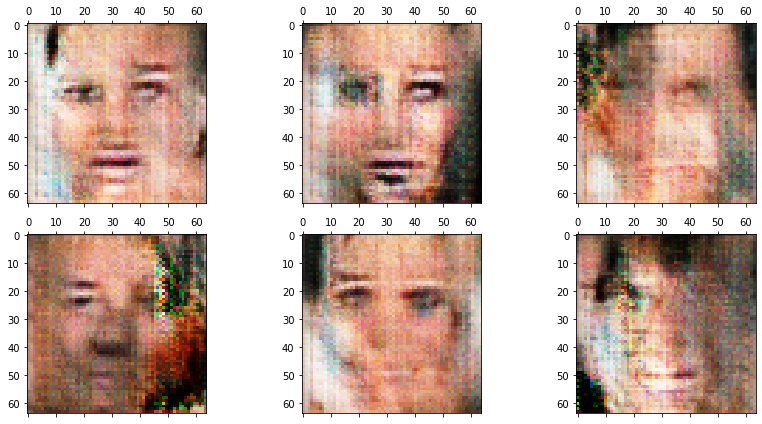

In [60]:
generator = Generator(100)
generator.built = True
critic = Critic((64, 64, 3), 5) ## 5???
critic.built = True

generator.load_weights('/content/gdrive/MyDrive/GAN Project/weights/WGAN/generator/34')
critic.load_weights('/content/gdrive/MyDrive/GAN Project/weights/WGAN/critic/34')

performance_summary(generator, 100)
#gan_model = WGANModel(generator, critic)
#gan_model.train(data_lowres, n_epochs=200, n_eval=1)

##Evaluacija modela


##Frechet Inception Distance

FID je metrika koja ukazuje na to koliko distribucija generisanih slika divergira od distribucije realnih slika na kojim je model treniran.
Da bismo izracunali FID koristimo već istreniran Inception V3 model i dimenzije slika postavimo na 75x75 pošto su to minimalne dimenzije koje Inception model prima. Veći FID ukazuje na lošiji kvalitet generisanih slika (slika ispod)

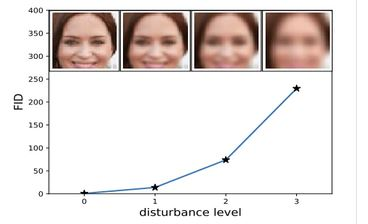

In [6]:
model = InceptionV3(include_top=False, pooling='avg', input_shape=(75,75,3))

87910968/87910968 [==============================] - 0s 0us/step


In [7]:
def calculate_fid(model, images1, images2):
 act1 = model.predict(images1)
 act2 = model.predict(images2)
 mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
 mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
 ssdiff = np.sum((mu1 - mu2)**2.0)
 covmean = sqrtm(sigma1.dot(sigma2))
 if iscomplexobj(covmean):
  covmean = covmean.real
 fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
 return fid

In [8]:
def scale_images(images, new_shape):
 images_list = []
 for image in images:
  new_image = resize(image, new_shape, 0)
  images_list.append(new_image)
 return asarray(images_list)

In [61]:
images_real = []
for i in range(30):
  batch = next(iter(data_lowres))
  for image in batch:
    images_real.append(image)

images_generated = generator(tf.random.normal(shape=(960, 100)))
generated_rescaled = scale_images(images_generated, (75, 75, 3))
real_rescaled = scale_images(images_real, (75, 75, 3))
real_processed = preprocess_input(generated_rescaled)
generated_processed = preprocess_input(real_rescaled)
fid = calculate_fid(model, real_processed, generated_processed)
print('Frechet inception distance za ovaj model je {}'.format(fid))

30/30 [==============================] - 0s 14ms/step
Frechet inception distance za ovaj model je 5.730813767008948


Pomoću haar cascade klasifikatora možemo proveriti na koliko generisanih slika se može detektovati lice

In [9]:
def extract_faces(images):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    # select the path
    # Extract faces from a subset of images to be used for training.
    images_extracted = []
    for image in images:
        image = image * 255.0
        image = np.array(image, dtype='uint8')
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5, 0)
        for (x, y, w, h) in faces:
            roi_color = image[y:y + h, x:x + w]
            resized = cv2.resize(roi_color, (64, 64))
            images_extracted.append(resized)
  
    return images_extracted


Lice je pronadjeno na 40.0% slika


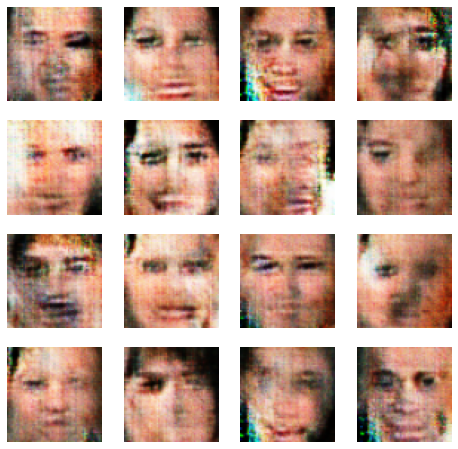

In [127]:
images_generated = generator(tf.random.normal(shape=(100, 100)))
images_extracted = extract_faces(images_generated)
print('Lice je pronadjeno na {}% slika'.format(len(images_extracted) / len(images_generated) * 100))
images_to_show = images_extracted[:16]
fig = plt.figure(figsize=(8,8))

for i in range(np.asarray(images_to_show).shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(np.asarray(images_to_show)[i, :, :] )
        
    plt.axis('off')

plt.show()

Rezultati eksperimenta su pokazali da WGAN nakon nekoliko epoha ostvari približno realističan prikaz slike. Usled ograničenog broja resursa nije bilo moguće dalje trenirati model. Iz tog razloga, rezultati eksperimenta nisu kvalitetni kao i oni koji su prikazani u naučnom radu.

In [38]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [39]:
ImgLocation = '/content/gdrive/MyDrive/GAN Project/extracted_faces'

data_lowres = keras.preprocessing.image_dataset_from_directory(
    directory=ImgLocation, label_mode=None, image_size=(64, 64), batch_size=32, shuffle=True 
).map(lambda x : x/255.0)


Found 22307 files belonging to 1 classes.


## Pomocne metode

In [49]:
# utils.py
import numpy as np
import matplotlib.pyplot as plt

def latent_vector(latent_dim, n):
    latent_input = np.random.randn(latent_dim * n)
    latent_input = latent_input.reshape(n, latent_dim)
    return latent_input


def fake_samples(generator, latent_dim, n):
    latent_output = latent_vector(latent_dim, n)
    X = generator(latent_output)
    return X

def performance_summary(generator, latent_dim, n=50):
    x_fake = fake_samples(generator, latent_dim, n)

    print("*** Evaluation ***")
    x_fake_inv_trans = x_fake.numpy().reshape(-1, 1)
    x_fake_inv_trans = x_fake_inv_trans.reshape(n, 64, 64, 3)

    fig, axs = plt.subplots(2, 3, sharey=False, tight_layout=True, figsize=(12, 6), facecolor='white')
    k = 0
    for i in range(0, 2):
        for j in range(0, 3):
            axs[i, j].matshow(x_fake_inv_trans[k])
            k = k + 1
    plt.show()


## Boundary equilibrium GAN

Boundary equilibrium GAN jeste model koji se nadovezuje na princip WGAN-a, ali ima potpuno drugačiju strukturu. Za generator se koristi dekoder, a za diskriminator, autoenkoder.

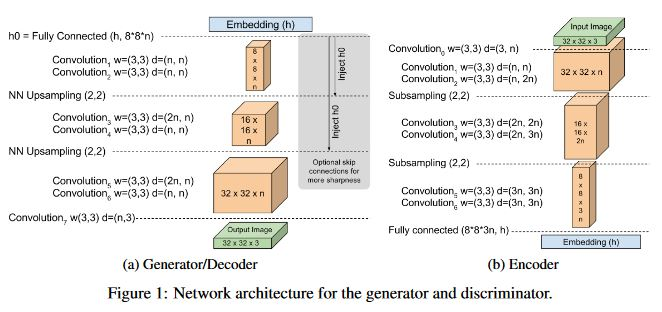

## Resize sloj
Koristi se za povecavanje dimenzija slike kod dekodera, odnosno smanjivanje kod enkodera

In [12]:
class Resize(layers.Layer):
    def __init__(self, image_size=(512, 512), **kwargs):
        self.image_size = image_size[0], image_size[1]
        super(Resize, self).__init__(**kwargs)

    def call(self, inputs, **kwargs):
        return tf.image.resize(inputs, self.image_size, method='nearest')

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.image_size[0], self.image_size[1], input_shape[-1]

## Blok kod enkodera i dekodera
Sastoji se od dva konvolutivna sloja i jednog *resize* sloja.

In [11]:
class Block(layers.Layer):
    def __init__(self, n_filters1, n_filters2, required_dimension, kernel=(3, 3), stride=(1, 1), **kwargs):
        super().__init__(**kwargs)
        self.cnv1_layer = Convolution2D(n_filters1, kernel, stride, padding='same', activation=tf.nn.elu)
        self.cnv2_layer = Convolution2D(n_filters2, kernel, stride, padding='same', activation=tf.nn.elu)
        self.upsample_layer1 = Resize([required_dimension, required_dimension])


    @tf.function
    def call(self, inputs, training=True):
        x = self.cnv1_layer(inputs, training=training)
        x = self.cnv2_layer(x, training=training)
        return self.upsample_layer1(x)

##Generator (Enkoder)
Sastoji se od 4 upsampling bloka

In [64]:
class Generator(tf.keras.Model):
    def __init__(self, latent_dim, required_dimension):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.n_nodes = 8 * 8 * 16
        self.fc1_layer = Dense(self.n_nodes, input_dim=(latent_dim,))
        self.reshape_layer = Reshape((8, 8, 16))
        self.decoder_block1 = Block(16, 16, required_dimension // 8)
        self.decoder_block2 = Block(32, 16, required_dimension // 4)
        self.decoder_block3 = Block(32, 16, required_dimension // 2)
        self.decoder_block4 = Block(32, 16, required_dimension)
        self.cnv1_layer = Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.elu)
        self.cnv2_layer = Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.elu)
        self.cnv3_layer = Convolution2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.elu)
        self.cnv4_layer = Convolution2D(filters=3, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='sigmoid')

    def call(self, input_tensor, training=False):
        x = self.fc1_layer(input_tensor, training=training)
        x = self.reshape_layer(x)
        x = self.decoder_block1(x, training=training)
        x = self.decoder_block2(x, training=training)
        x = self.decoder_block3(x, training=training)
        x = self.decoder_block4(x, training=training)
        x = self.cnv1_layer(x, training=training)
        x = self.cnv2_layer(x, training=training)
        x = self.cnv3_layer(x, training=training)
        return self.cnv4_layer(x)

##Diskriminator
Sastoji se od autoenkodera, odnosno dekodera koji je identicne strukuture kao onaj kod generatora i enkodera koji se sastoji od 4 downsampling bloka 

In [14]:
class Discriminator(tf.keras.Model):
    def __init__(self, latent_dim, required_dimension):
        super(Discriminator, self).__init__()
        input_shape = [required_dimension, required_dimension, 3]
        self.inputs = Input(shape=input_shape)
        self.encoder_block1 = Block(16, 32, required_dimension)
        self.encoder_block2 = Block(32, 48, required_dimension // 2)
        self.encoder_block3 = Block(48, 48, required_dimension // 4)
        self.encoder_block4 = Block(48, 48, required_dimension // 8)
        self.flatten = Flatten()
        self.dense1 = Dense(8 * 8 * 3 * 16)
        self.dense2 = Dense(latent_dim)
        self.n_nodes = 8 * 8 * 16
        self.fc1_layer = Dense(self.n_nodes, input_dim=(latent_dim,))
        self.reshape_layer = Reshape((8, 8, 16))
        self.decoder_block1 = Block(16, 16, required_dimension // 8)
        self.decoder_block2 = Block(32, 16, required_dimension // 4)
        self.decoder_block3 = Block(32, 16, required_dimension // 2)
        self.decoder_block4 = Block(32, 16, required_dimension)
        self.cnv1_layer = Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.elu)
        self.cnv2_layer = Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.elu)
        self.cnv3_layer = Convolution2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.elu)
        self.cnv4_layer = Convolution2D(filters=3, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='sigmoid')

    def call(self, input_tensor, training=False):
        x = self.encoder_block1(input_tensor, training=training)
        x = self.encoder_block2(x, training=training)
        x = self.encoder_block3(x, training=training)
        x = self.encoder_block4(x, training=training)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.fc1_layer(x, training=training)
        x = self.reshape_layer(x)
        x = self.decoder_block1(x, training=training)
        x = self.decoder_block2(x, training=training)
        x = self.decoder_block3(x, training=training)
        x = self.decoder_block4(x, training=training)
        x = self.cnv1_layer(x, training=training)
        x = self.cnv2_layer(x, training=training)
        x = self.cnv3_layer(x, training=training)
        return self.cnv4_layer(x, training=training)

## Loss funkcija
Koristi se wasserstein distanca ali sa dve promene.
  1. Ne želimo da izjednačimo distribuciju između primeraka realnih i generisanih slika, već između *loss* vrednosti diskriminatora po generisanim i realnim slikama. *Loss* diskriminatora dobijamo kao razliku između slike na ulasku u enkoder i rekonstruisane slike na izlasku iz dekodera. 
  2. Ne zahteva se da diskriminator bude K-Lipschitz kontinualan.

In [15]:
def began_autoencoder_loss(out, inp):
    diff = tf.abs(out-inp)
    return tf.reduce_mean(diff)

## Ravnoteža između diskriminatora i generatora

\begin{align}y = \frac{\mathbb{E}[L(G(z))]}{\mathbb{E}[L(x)]}\end{align}

Kako bi održali balans između diskriminatora i generatora, uveden je **y** parametar. Pomoću njega možemo kontrolisati kvalitet i diverzitet generisanih slika. Za manje vrednosti **y** dobijamo kvalitetnije slike ali generator lakše upada u *mode collapse* - fenomen gde generator generiše slične ili iste slike za različite latentne vektore. Za veće **y** dobijamo slike slabijeg kvaliteta ali većeg diverziteta

##BEGAN algoritam



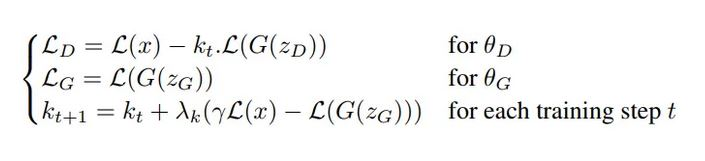

Da bi se održala ravnoteža između *loss*-ova generatora i diskriminatora uveden je parametar k_t koji pripada [0, 1] i kontroliše koliko se značaja daje **loss**-u generatora tokom treniranja. Sam parametar k_t se ažurira tokom treniranja pomoću parametra lambda_k koji praktično služi kao learning rate i inicijalno se postavlja na 0.001.

##Mera Konvergencije
\begin{aligned}M_{global} = L(x) + |yL(x) - L(G(z)|\end{aligned}

##Treniranje modela
Treniramo BEGAN iterativno optimizujući diskriminator i generator koristeci *Adam* algoritam.

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)


class BEGAN:
    def __init__(self, generator, critic, gamma):
        self.generator = generator
        self.discriminator = critic
        self.gamma = gamma

    @staticmethod
    def began_autoencoder_loss(out, inp):
        diff = tf.abs(out-inp)
        return tf.reduce_mean(diff)

    def get_loss_values(self, k_t, gamma, d_real_in, d_real_out, d_gen_in, d_gen_out):
        ae_real = self.began_autoencoder_loss(d_real_out, d_real_in)
        ae_gen = self.began_autoencoder_loss(d_gen_out, d_gen_in)

        d_loss = ae_real - k_t * ae_gen
        g_loss = ae_gen

        lambda_v = 0.001
        k_tp = k_t + lambda_v * (gamma * ae_real - ae_gen)

        convergence_measure = ae_real + np.abs(gamma * ae_real - ae_gen)

        return g_loss, d_loss, k_tp, convergence_measure

    def train_step(self, k_t, images, batch_size):

        d_gen_in = tf.random.normal([batch_size, self.generator.latent_dim])
        d_real_in = images

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(d_gen_in, training=True)

            d_generated_images = self.discriminator(generated_images, training=True)
            discriminated_images = self.discriminator(d_real_in, training=True)

            gen_loss, disc_loss, k_t, convergence_measure = self.get_loss_values(k_t, self.gamma, d_real_in, discriminated_images, generated_images, d_generated_images)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        return gen_loss, disc_loss, k_t, convergence_measure

    def train(self, dataset, n_epochs=100, n_batch=16, n_images=1000):
        step_size = n_images // n_batch
        k_t = 0.0
        step = 0
        convergence_measure = 0.0
        seed = tf.random.normal([16, self.generator.latent_dim])
        for epoch in range(n_epochs):
            g_loss = 0
            d_loss = 0
            for _ in range(step_size):
                g_loss, d_loss, k_t, convergence_measure = self.train_step(min(max(k_t, 0.0), 1.0),
                                                                      next(iter(dataset)), n_batch)
                step += 1

                if (step % 300 == 0):
                    print('Generator loss:{} Discrimantor loss:{} Convergence:{} K_t:{} step: {}'.format(g_loss, d_loss,
                                                                                                         convergence_measure,
                                                                                                        k_t, step))
                    self.generator.save_weights('/content/gdrive/MyDrive/GAN Project/weights/BEGAN/generator/' + str(step))
                    self.discriminator.save_weights('/content/gdrive/MyDrive/GAN Project/weights/BEGAN/generator/' + str(step))
                    generate_and_save_images(self.generator,
                                             epoch + 1,
                                             seed)

            print('Generator loss:{} Discrimantor loss:{} Convergence:{} K_t:{} step: {}'.format(g_loss, d_loss,
                                                                                                 convergence_measure,
                                                                                                 k_t, step))
            generate_and_save_images(self.generator,
                                     epoch + 1,
                                     seed)

        generate_and_save_images(self.generator,
                                 n_epochs,
                                 seed)

In [1]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(8,8))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :] )
            
        plt.axis('off')

    plt.show()

In [ ]:
generator = Generator(128, 64)
discriminator = Discriminator(128, 64) 
gan_model = BEGAN(generator, discriminator, 0.7)
gan_model.train(dataset, n_epochs=200, n_batch=16,  n_images=202599)

##Primeri treniranja

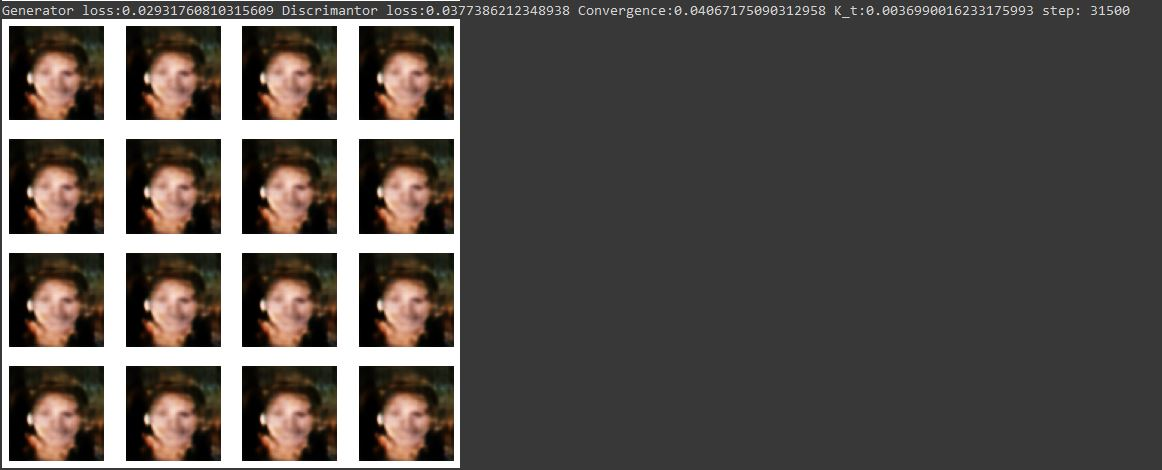

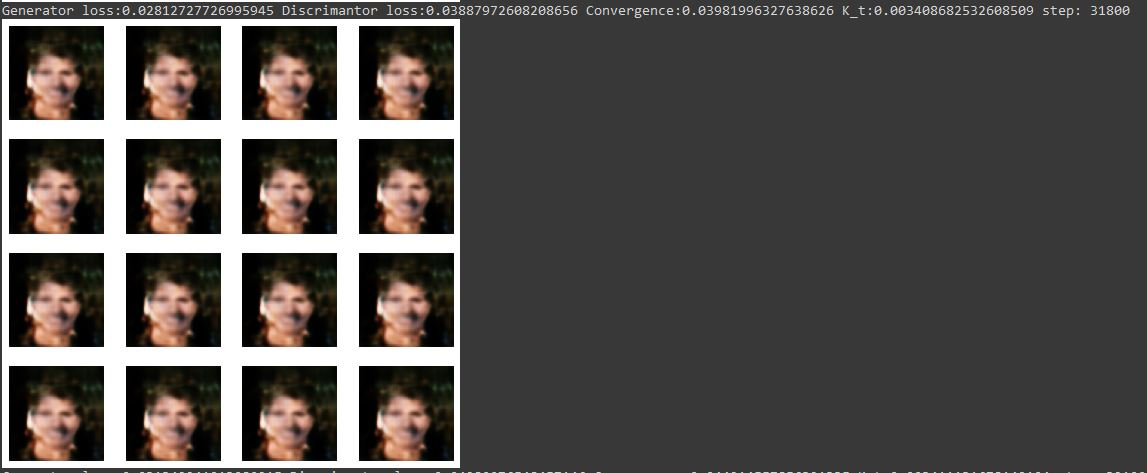

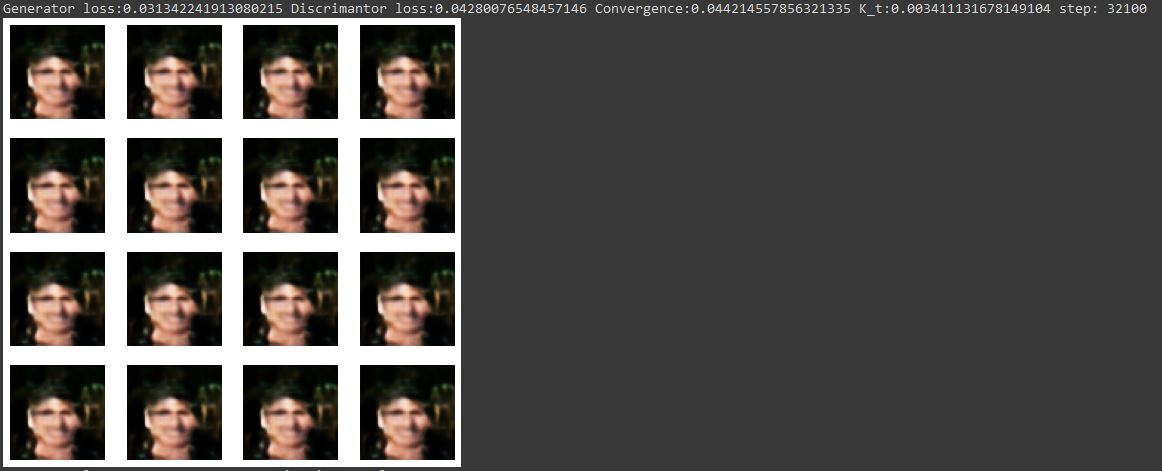

Može se primetiti da je kvalitet slike bolji nego onaj kod WGAN-a, ali je sad problem to što je model upao u tzv. *Mode Collapse* i generise jednu identičnu sliku, ovo se desi kada se diskriminator pronađe u lokalnom minimumu, a generator nađe primerak koji uspe da prevari diskriminator. Ovo se može popraviti boljim odabirom *learning rate*-a i gama parametra, ali zbog ograničenih resursa nije bilo dovoljno vremena za optimizaciju.

##Evaluacija modela

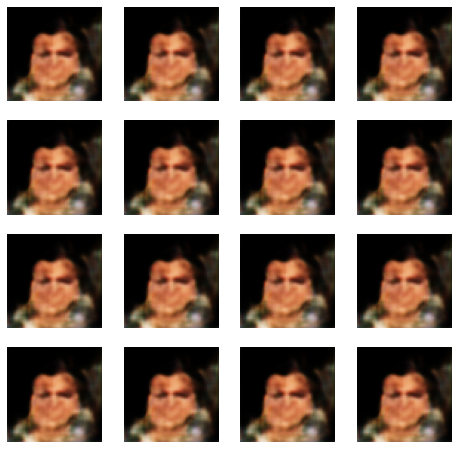

In [66]:
generator = Generator(128, 64)
generator.load_weights('/content/gdrive/MyDrive/GAN Project/weights/BEGAN/generator/19200')
generate_and_save_images(generator, 0, tf.random.normal([16, 128]))

##Frechet inception distance

In [67]:
images_real = []
for i in range(60):
  batch = next(iter(dataset))
  for image in batch:
    images_real.append(image)

images_generated = generator(tf.random.normal(shape=(960, 128)))
generated_rescaled = scale_images(images_generated, (75, 75, 3))
real_rescaled = scale_images(images_real, (75, 75, 3))
real_processed = preprocess_input(generated_rescaled)
generated_processed = preprocess_input(real_rescaled)
fid = calculate_fid(model, real_processed, generated_processed)
print('Frechet inception distance za ovaj model je {}'.format(fid))

30/30 [==============================] - 0s 14ms/step
Frechet inception distance za ovaj model je 67.91535932947711


Zbog *mode collapse*-a generator ne uspeva da pokrije distribuciju realnih slika i FID je veći nego onaj kod WGAN-a.

## Ucitavanje skupa preko kaggle-a

In [ ]:
! pip install kaggle

In [22]:
! mkdir ~/.kaggle

In [23]:
! cp kaggle.json ~/.kaggle/

In [24]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d jessicali9530/celeba-dataset

In [ ]:
! unzip celeba-dataset.zip

In [ ]:
dataset = keras.preprocessing.image_dataset_from_directory(
    directory='/content/img_align_celeba/img_align_celeba', label_mode=None, image_size=(64, 64), batch_size=16, shuffle=True 
).map(lambda x : x/255.0)